In [1]:
import numpy as np
import tensorflow as tf
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
os.chdir('../')
from function import make_data

In [87]:
import matplotlib.pyplot as plt

In [64]:
df = make_data(dt = 0.01, total_time = 100)

In [66]:
train_df = df.iloc[:9000,:]
test_df = df.iloc[9000:,:]

def func(t):
    u = np.interp(t, data_df['time'], data_df['u'])
    f = np.interp(t, data_df['time'], data_df['f'])
    return u, f

def input_transform(u, t):
    t_tf = tf.convert_to_tensor(t, dtype=tf.float32)
    u_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    return tf.concat([u, t], axis=1)


In [152]:
alpha, beta, gamma = dde.Variable(-45.93857163), dde.Variable(117.18149753), dde.Variable(63.07236099)

In [146]:
def bouc_wen(u, t):
    du_dt = dde.grad.jacobian(tf.reshape(tf.convert_to_tensor(train_df['u']), [-1,1]), 
                    tf.reshape(tf.convert_to_tensor(train_df['time']), [-1,1]))    # z = u
    # du_dt = -alpha * z - beta * z * tf.abs(z) - gamma * z**2
    
    return [du_dt]


In [122]:
total_data = dde.data.dataset.DataSet(
    X_train = train_df[['u','time']].values, 
    y_train = train_df['f'].values.reshape(-1,1),                     
    X_test = test_df[['u','time']].values, 
    y_test = test_df['f'].values.reshape(-1,1),
    solution = bouc_wen)

TypeError: DataSet.__init__() got an unexpected keyword argument 'solution'

data = dde.data.PDE(
    total_data,
    bouc_wen,
    bcs=[],
    num_domain=9000,
    num_boundary=0,
    solution=None,
    num_test=1000,
    train_distribution="uniform",
)


In [76]:
import matplotlib.pyplot as plt

In [77]:
net = dde.maps.FNN([2] + [200] * 2 + [1], "relu", "Glorot normal")

In [110]:
model = dde.Model(data = total_data, net = net)

In [111]:
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.080818 s



In [112]:
losshistory, train_state = model.train(epochs=6000)

Training model...

Step      Train loss    Test loss     Test metric
0         [9.53e-01]    [6.39e-01]    []  
1000      [1.29e-01]    [2.27e-01]    []  
2000      [1.26e-01]    [2.62e-01]    []  
3000      [1.06e-01]    [1.94e-01]    []  
4000      [1.08e-01]    [2.03e-01]    []  
5000      [1.06e-01]    [1.82e-01]    []  
6000      [1.06e-01]    [1.73e-01]    []  

Best model at step 6000:
  train loss: 1.06e-01
  test loss: 1.73e-01
  test metric: []

'train' took 74.456741 s



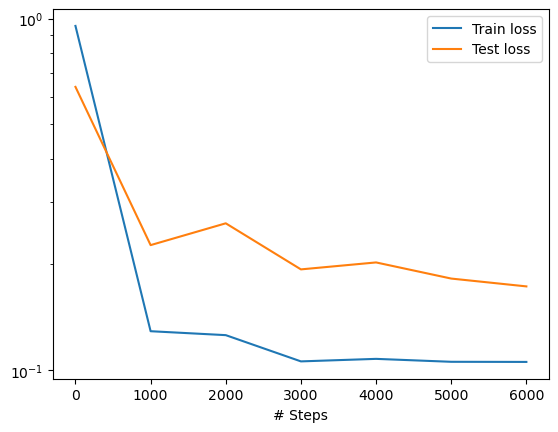

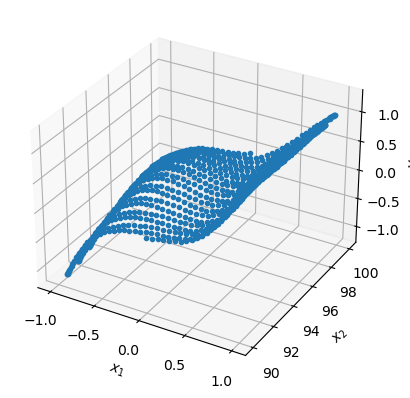

In [113]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

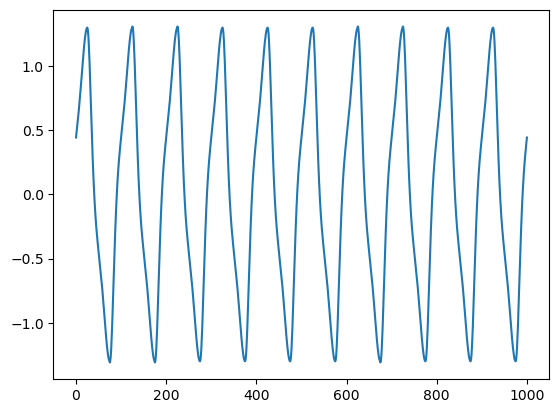

In [114]:
plt.plot(test_df['f'].values)

In [115]:
test_df['f']

9000     0.443936
9001     0.477048
9002     0.510083
9003     0.543512
9004     0.577739
           ...   
9996     0.299485
9997     0.338637
9998     0.375329
9999     0.410222
10000    0.443936
Name: f, Length: 1001, dtype: float64

In [116]:
model.predict(test_df[['u','time']])

array([[ 0.00285575],
       [ 0.02096033],
       [ 0.03690749],
       ...,
       [-0.14200026],
       [-0.12145738],
       [-0.09201346]], dtype=float32)

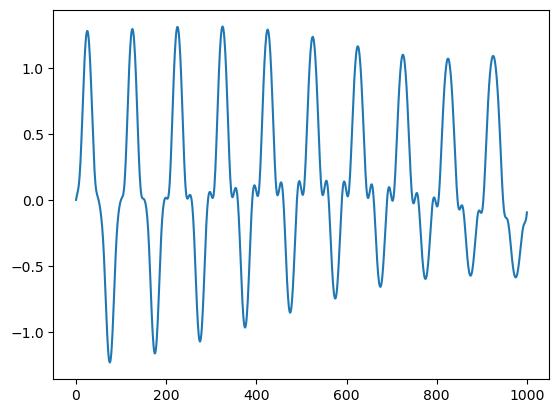

In [117]:
plt.plot(model.predict(test_df[['u','time']].values), label = 'pred')


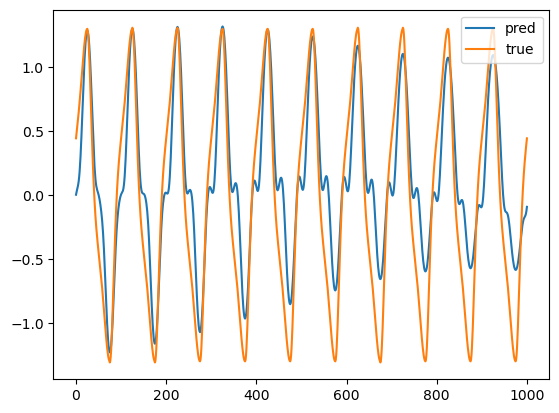

In [118]:
plt.plot(model.predict(test_df[['u','time']].values), label = 'pred')
plt.plot(test_df['f'].values, label = 'true')
plt.legend()
plt.show()

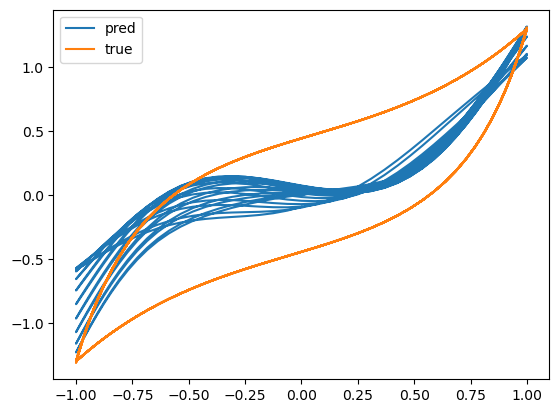

In [119]:
plt.plot(test_df['u'], model.predict(test_df[['u','time']].values), label = 'pred')
plt.plot(test_df['u'], test_df['f'].values, label = 'true')
plt.legend()
plt.show()